In [1]:
import os
import sys
import warnings
import math
import numpy as np
import pandas as pd
import platform
import re
import subprocess
import torch as th
import pickle
import gymnasium as gym
import matplotlib.pyplot as plt
from datetime import datetime
from scripts.utils import (
    load_scenario_data,
    verify_training_folders,
    create_results_directory,
    get_model_version,
    format_days,
    calculate_training_days,
    initialize_device,
    check_device_capabilities,
    get_device_info,
)
from scripts.visualizations import *
from src.config import *
from sb3_contrib import MaskablePPO
from stable_baselines3.common.logger import configure
from stable_baselines3.common.vec_env import DummyVecEnv
from sb3_contrib.common.wrappers import ActionMasker
from src.environment import AircraftDisruptionEnv

# Constants and Training Settings
LEARNING_RATE = 0.001
GAMMA = 0.99
BUFFER_SIZE = 50000 * 2
BATCH_SIZE = 64 * 4
TARGET_UPDATE_INTERVAL = 100
MAX_TIMESTEPS = 50000
NEURAL_NET_STRUCTURE = dict(net_arch=[256, 256 * 2, 256])
LEARNING_STARTS = 0
TRAIN_FREQ = 4
EPSILON_START = 1.0
EPSILON_MIN = 0.025
PERCENTAGE_MIN = 95
N_EPISODES = 50
TRAINING_FOLDERS_PATH = "../data/Training/3ac-single-cleared/"
TESTING_FOLDERS_PATH = "../data/Testing/3ac-single-cleared/"

# Initialize device
device = initialize_device()
check_device_capabilities()
device_info = get_device_info(device)
print(f"Device info: {device_info}")

# Verify training folders and gather training data
training_folders = verify_training_folders(TRAINING_FOLDERS_PATH)
print(f"Training folders: {training_folders}")

# Calculate training days and model naming
num_days_trained_on = calculate_training_days(N_EPISODES, training_folders)
print(f"Training on {num_days_trained_on} days of data "
      f"({N_EPISODES} episodes of {len(training_folders)} scenarios)")

formatted_days = format_days(num_days_trained_on)
last_folder = os.path.basename(os.path.normpath(TRAINING_FOLDERS_PATH))
model_name = last_folder
model_version = get_model_version(model_name)
MODEL_SAVE_PATH = f'../trained_models/ppo/'
MODEL_SAVE_NAME = f'{model_name}-{formatted_days}-{model_version}.zip'
print(f"Models will be saved to:")
print(f"   {MODEL_SAVE_PATH}myopic_{MODEL_SAVE_NAME}")
print(f"   {MODEL_SAVE_PATH}proactive_{MODEL_SAVE_NAME}")

# Create results directory
results_dir = create_results_directory(append_to_name='ppo')
print(f"Results directory created at: {results_dir}")

def get_action_masks(env):
    return env.get_action_mask()

def train_ppo_agent(env_type):
    rewards = []
    total_timesteps = 0
    scenario_folders = [
        os.path.join(TRAINING_FOLDERS_PATH, folder)
        for folder in os.listdir(TRAINING_FOLDERS_PATH)
        if os.path.isdir(os.path.join(TRAINING_FOLDERS_PATH, folder))
    ]

    class ScenarioEnvWrapper(gym.Env):
        def __init__(self, scenario_folders, env_type):
            super(ScenarioEnvWrapper, self).__init__()
            self.scenario_folders = scenario_folders
            self.env_type = env_type
            self.current_scenario_idx = -1
            self.load_next_scenario()

            self.observation_space = self.env.observation_space
            self.action_space = self.env.action_space

        def load_next_scenario(self):
            self.current_scenario_idx = (self.current_scenario_idx + 1) % len(self.scenario_folders)
            scenario_folder = self.scenario_folders[self.current_scenario_idx]
            data_dict = load_scenario_data(scenario_folder)
            aircraft_dict = data_dict['aircraft']
            flights_dict = data_dict['flights']
            rotations_dict = data_dict['rotations']
            alt_aircraft_dict = data_dict['alt_aircraft']
            config_dict = data_dict['config']

            self.env = AircraftDisruptionEnv(
                aircraft_dict,
                flights_dict,
                rotations_dict,
                alt_aircraft_dict,
                config_dict,
                env_type=self.env_type
            )

        def reset(self, seed=None, options=None):
            self.load_next_scenario()
            result = self.env.reset(seed=seed, options=options)
            return result

        def step(self, action):
            return self.env.step(action)

        def render(self, mode='human'):
            return self.env.render(mode=mode)

        def close(self):
            return self.env.close()

        def get_action_mask(self):
            return self.env.get_action_mask()

    env = ScenarioEnvWrapper(scenario_folders, env_type)
    env = ActionMasker(env, get_action_masks)
    env = DummyVecEnv([lambda: env])

    model = MaskablePPO(
        'MultiInputPolicy',
        env,
        learning_rate=LEARNING_RATE,
        gamma=GAMMA,
        verbose=1,
        tensorboard_log=f"./ppo_aircraft_tensorboard_{env_type}/",
        device=device,
        policy_kwargs=NEURAL_NET_STRUCTURE
    )

    logger = configure()
    model.set_logger(logger)

    timesteps_per_episode = MAX_TIMESTEPS // N_EPISODES

    for episode in range(N_EPISODES):
        print(f"{env_type}: Episode {episode + 1}/{N_EPISODES} started.")
        obs = env.reset()
        done = False
        episode_rewards = []

        while not done:
            action, _states = model.predict(obs, deterministic=False)
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)

        total_reward = sum(episode_rewards)
        rewards.append(total_reward)
        print(f"Episode {episode + 1}: Reward: {total_reward}")

        model.learn(total_timesteps=timesteps_per_episode, reset_num_timesteps=False)
        total_timesteps += timesteps_per_episode

        print(f"{env_type}: Episode {episode + 1}/{N_EPISODES} completed.")

    model.save(f"{MODEL_SAVE_PATH}{env_type}_{MODEL_SAVE_NAME}")
    return rewards, total_timesteps

start_time = datetime.now()

results_myopic = train_ppo_agent('myopic')
results_proactive = train_ppo_agent('proactive')

rewards_myopic, total_timesteps_myopic = results_myopic
rewards_proactive, total_timesteps_proactive = results_proactive

myopic_rewards_file = os.path.join(results_dir, "rewards_myopic.pkl")
with open(myopic_rewards_file, "wb") as file:
    pickle.dump(rewards_myopic, file)
print(f"Myopic rewards saved to {myopic_rewards_file}")

proactive_rewards_file = os.path.join(results_dir, "rewards_proactive.pkl")
with open(proactive_rewards_file, "wb") as file:
    pickle.dump(rewards_proactive, file)
print(f"Proactive rewards saved to {proactive_rewards_file}")

end_time = datetime.now()
runtime = (end_time - start_time).total_seconds()
print(f"Total training time: {runtime} seconds")


Using device: mps
CUDA available: False
Number of GPUs available: 0
cuDNN enabled: True
Device: mps
Using MacBook M1
Device info: {'device_type': 'MacBook M1'}
Training folders: ['Scenario_01']
Training on 50 days of data (50 episodes of 1 scenarios)
Getting model version for 3ac-single-cleared
Models will be saved to:
   ../trained_models/ppo/myopic_3ac-single-cleared-50-1.zip
   ../trained_models/ppo/proactive_3ac-single-cleared-50-1.zip
Results directory created at: ../results/ppo/20241123-20-41
Using mps device
Logging to /var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/SB3-2024-11-23-20-41-02-354934
-----------------------------
| time/              |      |
|    fps             | 164  |
|    iterations      | 1    |
|    time_elapsed    | 12   |
|    total_timesteps | 2048 |
-----------------------------
myopic: Episode 1/50 completed.
-----------------------------------------
| time/                   |             |
|    fps                  | 167         |
|    iterations     

/Users/pieterbecking/Desktop/Boeing-ADM-DRL-Github/.venv/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:284: UserWarning: Path '../trained_models/ppo' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


-----------------------------
| time/              |      |
|    fps             | 166  |
|    iterations      | 1    |
|    time_elapsed    | 12   |
|    total_timesteps | 2048 |
-----------------------------
proactive: Episode 1/50 completed.
-----------------------------------------
| time/                   |             |
|    fps                  | 167         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.061826073 |
|    clip_fraction        | 0.466       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.04       |
|    explained_variance   | -4.53e-06   |
|    learning_rate        | 0.001       |
|    loss                 | 1.17e+06    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0613     |
|    value_loss           | 2.59e+06    |
-----------------------------------------

In [2]:
import pickle


# Save the myopic rewards
myopic_rewards_file = os.path.join(results_dir, "rewards_myopic.pkl")
with open(myopic_rewards_file, "wb") as file:
    pickle.dump(rewards_myopic, file)
print(f"Myopic rewards saved to {myopic_rewards_file}")

# Save the proactive rewards
proactive_rewards_file = os.path.join(results_dir, "rewards_proactive.pkl")
with open(proactive_rewards_file, "wb") as file:
    pickle.dump(rewards_proactive, file)
print(f"Proactive rewards saved to {proactive_rewards_file}")

end_time = datetime.now()
runtime = end_time - start_time
runtime_in_seconds = runtime.total_seconds()
print(f"Total training time: {runtime_in_seconds} seconds")

Myopic rewards saved to ../results/ppo/20241123-20-41/rewards_myopic.pkl
Proactive rewards saved to ../results/ppo/20241123-20-41/rewards_proactive.pkl
Total training time: 1717.463233 seconds


In [3]:
from src.config import *

# Create a dictionary of all hyperparameters and system information
hyperparameters = {
    "Parameter": [
        "MODEL_TYPE",
        "LEARNING_RATE", "GAMMA", "BUFFER_SIZE", "BATCH_SIZE",
        "TARGET_UPDATE_INTERVAL", "MAX_TIMESTEPS", "LEARNING_STARTS",
        "TRAIN_FREQ", "N_EPISODES", "NEURAL_NET_STRUCTURE",
        "TRAINING_FOLDERS_PATH", "TESTING_FOLDERS_PATH", "MODEL_SAVE_PATH",
        "MODEL_SAVE_NAME", "runtime_in_seconds", "runtime_in_hh:mm:ss",
        "total_timesteps_myopic", "total_timesteps_proactive", "device",
        "device_info", "MAX_AIRCRAFT", "MAX_FLIGHTS_PER_AIRCRAFT",
        "TIMESTEP_HOURS", "DUMMY_VALUE", "RESOLVED_CONFLICT_REWARD",
        "DELAY_MINUTE_PENALTY", "MAX_DELAY_PENALTY", "NO_ACTION_PENALTY",
        "CANCELLED_FLIGHT_PENALTY", "MIN_TURN_TIME", "CROSS_VAL_INTERVAL",
        "PERCENTAGE_MIN"
    ],
    "Value": [
        "PPO", LEARNING_RATE, GAMMA, BUFFER_SIZE, BATCH_SIZE,
        TARGET_UPDATE_INTERVAL, MAX_TIMESTEPS, LEARNING_STARTS,
        TRAIN_FREQ, N_EPISODES, str(NEURAL_NET_STRUCTURE),
        TRAINING_FOLDERS_PATH, TESTING_FOLDERS_PATH, MODEL_SAVE_PATH,
        MODEL_SAVE_NAME, runtime_in_seconds, str(runtime),
        total_timesteps_myopic, total_timesteps_proactive, device,
        str(device_info), MAX_AIRCRAFT, MAX_FLIGHTS_PER_AIRCRAFT,
        TIMESTEP_HOURS, DUMMY_VALUE, RESOLVED_CONFLICT_REWARD,
        DELAY_MINUTE_PENALTY, MAX_DELAY_PENALTY, NO_ACTION_PENALTY,
        CANCELLED_FLIGHT_PENALTY, MIN_TURN_TIME, CROSS_VAL_INTERVAL,
        PERCENTAGE_MIN
    ]
}

# Convert the dictionary to a DataFrame
hyperparameters_df = pd.DataFrame(hyperparameters)

# Define the path for the CSV file
csv_file_path = os.path.join(results_dir, "hyperparameters.csv")

# Save the DataFrame to a CSV file
hyperparameters_df.to_csv(csv_file_path, index=False)
print(f"All hyperparameters saved to {csv_file_path}")


All hyperparameters saved to ../results/ppo/20241123-20-41/hyperparameters.csv


[]


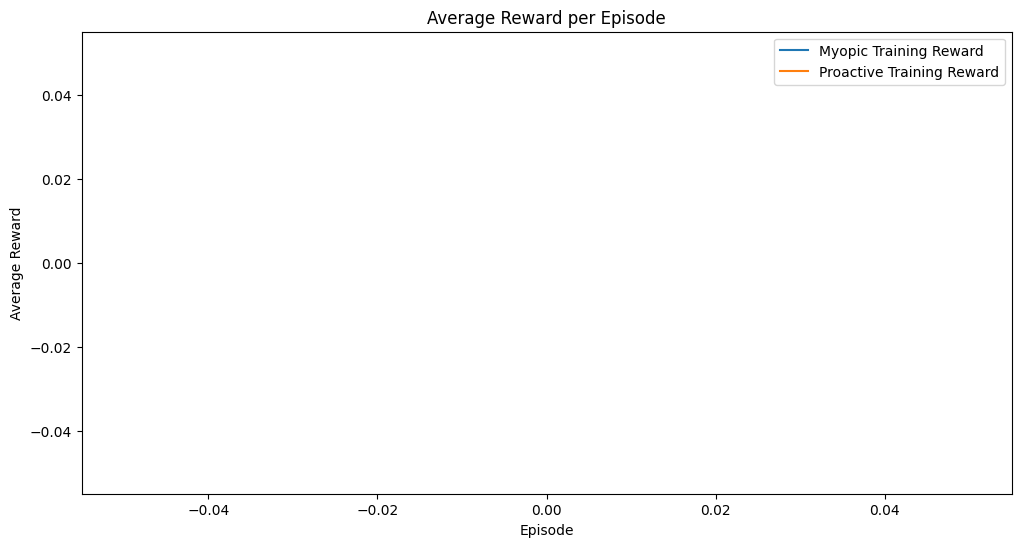

In [6]:
# Process training rewards per episode for myopic
print(rewards_myopic)
episodes_myopic = [ep for ep, _ in rewards_myopic]
avg_rewards_per_episode_myopic = [reward for _, reward in rewards_myopic]

# Process training rewards per episode for proactive
episodes_proactive = [ep for ep, _ in rewards_proactive]
avg_rewards_per_episode_proactive = [reward for _, reward in rewards_proactive]

# Extract test rewards for myopic
# test_episodes_myopic = [ep for ep, _ in test_rewards_myopic]
# test_avg_rewards_myopic = [reward for _, reward in test_rewards_myopic]

# # Extract test rewards for proactive
# test_episodes_proactive = [ep for ep, _ in test_rewards_proactive]
# test_avg_rewards_proactive = [reward for _, reward in test_rewards_proactive]

# Plot the average rewards over the episodes
plt.figure(figsize=(12, 6))

# Plot training rewards
plt.plot(episodes_myopic, avg_rewards_per_episode_myopic, label='Myopic Training Reward', color='C0')
plt.plot(episodes_proactive, avg_rewards_per_episode_proactive, label='Proactive Training Reward', color='C1')


# plt.plot(test_episodes_myopic, test_avg_rewards_myopic, label='Myopic Test Reward', color='C0', linestyle='--')
# plt.plot(test_episodes_proactive, test_avg_rewards_proactive, label='Proactive Test Reward', color='C1', linestyle='--')

plt.legend()
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Reward per Episode')
plt.savefig(os.path.join(results_dir, 'plots', 'average_reward_per_episode.png'))
plt.show()
